In [2]:
import pandas as pd 

import matplotlib.pyplot as plt
import scikitplot as skplt

# we use tensorflow to create our neural network for this experiment 
import tensorflow as tf 
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [4]:
# import scarcity labeled ads
df = pd.read_csv('data/scarcity_dataset.csv')
df

,ad,scarcity
0,it’s almost over the shortcut law that lets yo...,1
1,on sale this week sequel to nyt bestseller pro...,1
2,refugees are especially vulnerable to the dang...,1
3,we are motivating reminding and supporting vot...,1
4,the future of decentralized nomadic coliving i...,1
...,...,...
17995,parents take part in the study of the impact o...,0
17996,lincoln news lincoln mayor orders greater rest...,0
17997,joe biden beat the nra twice he got assault we...,0
17998,reid nearly lost his eye to cancer thanks to t...,0


In [5]:
norm_train, norm_test,  y_train, y_test = train_test_split(df['ad'], df['scarcity'], test_size =0.2, random_state=42)

In [6]:
# data tokenization 
t = tf.keras.preprocessing.text.Tokenizer(oov_token='<UNK>')

# fit the tokenizer on the training documents
t.fit_on_texts(norm_train)
t.word_index['<PAD>'] = 0
max([(k, v) for k, v in t.word_index.items()], key = lambda x:x[1]), min([(k, v) for k, v in t.word_index.items()], key = lambda x:x[1]), t.word_index['<UNK>']

(('httpbitlyyekel', 39498), ('<PAD>', 0), 1)

In [7]:
# create tokenized data sequences to feed to the neural network 
train_sequences = t.texts_to_sequences(norm_train)
test_sequences = t.texts_to_sequences(norm_test)

In [8]:
MAX_SEQUENCE_LENGTH = 1000

# pad documents to equal length with 0 
X_train = tf.keras.preprocessing.sequence.pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_test = tf.keras.preprocessing.sequence.pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_train.shape, X_test.shape

((14400, 1000), (3600, 1000))

In [9]:
def create_model(units, vocab_size, embedding_dim, maxlen, dropout = 0.2):
  '''
    Create a 
    Arguments : 
      num_filters: number of filters to use for the 1D convolution layer 
      kernel_size: kernal size used for convolution
      embedding_dim: embedding size 
      maxlen: input sequence length
      vectorize_layer : vectorization layer for turning input text to numerical sequences
      dropout : dropout rate used for Dropout regularization layer to minimize overfitting

    Returns : 
    A model with the folowing layers:  
            - An Embedding layer with embedding_dim dimension for each embedding 
            - A one dimentional (1D) convolutional neural network
            - A one dimentional global max pooling layer  
            - A fully connected layer with 10 units 
            - The output layer is one neuron with sigmoid activation producing the output label
            - Dropout layers added to minimize overfitting on the small datasets 
  '''
  model = Sequential([
      layers.Input(shape=(maxlen,)),
      layers.Embedding(input_dim = vocab_size , output_dim = embedding_dim, input_length=maxlen),
      layers.Dropout( rate = dropout ),
      layers.GlobalMaxPooling1D(),
      layers.Dropout( rate = dropout),
      layers.Dense(units, activation='relu'),
      layers.Dropout( rate = dropout ),
      layers.Dense(1, activation='sigmoid')              
  ])
  model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])
  return model

In [10]:
VOCAB_SIZE = len(t.word_index)
EMBEDDING_DIM = 128
UNITS = 10

# Creating a neural net with randomly set paramteres as a baseline comparison model 
model = create_model(units = UNITS, vocab_size = VOCAB_SIZE, embedding_dim = EMBEDDING_DIM, maxlen = MAX_SEQUENCE_LENGTH )
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1000, 128)         5055872   
                                                                 
 dropout (Dropout)           (None, 1000, 128)         0         
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense (Dense)               (None, 10)                1290      
                                                                 
 dropout_2 (Dropout)         (None, 10)                0         
                                                        

2022-06-02 17:34:55.323954: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-02 17:34:58.484074: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10417 MB memory:  -> device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:02:00.0, compute capability: 6.1


In [11]:
# Train the neural net and evaluate results 
history = model.fit(X_train, y_train, epochs= 5, batch_size= 32,  shuffle=True, validation_split=0.2, verbose=1)
model.save('scarcity_model.h5')

Epoch 1/5
360/360 [==============================] - 4s 7ms/step - loss: 0.5361 - accuracy: 0.7468 - val_loss: 0.2928 - val_accuracy: 0.9080
Epoch 2/5
360/360 [==============================] - 2s 7ms/step - loss: 0.2252 - accuracy: 0.9146 - val_loss: 0.1655 - val_accuracy: 0.9431
Epoch 3/5
360/360 [==============================] - 2s 7ms/step - loss: 0.1463 - accuracy: 0.9451 - val_loss: 0.1338 - val_accuracy: 0.9535
Epoch 4/5
360/360 [==============================] - 2s 7ms/step - loss: 0.1069 - accuracy: 0.9619 - val_loss: 0.1266 - val_accuracy: 0.9528
Epoch 5/5
360/360 [==============================] - 2s 7ms/step - loss: 0.0782 - accuracy: 0.9731 - val_loss: 0.1182 - val_accuracy: 0.9552


In [12]:
# model evaluation 
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

113/113 [==============================] - 0s 3ms/step - loss: 0.1067 - accuracy: 0.9603
Accuracy: 96.03%


In [13]:
# get model predictions 
prediction_probs = model.predict(X_test, verbose=1).ravel()
predictions = [1 if prob > 0.5 else 0 for prob in prediction_probs]
predictions[:10]

113/113 [==============================] - 0s 2ms/step


[1, 1, 0, 1, 1, 0, 1, 1, 0, 0]

              precision    recall  f1-score   support

 no-scarcity       0.97      0.95      0.96      1781
    scarcity       0.95      0.97      0.96      1819

    accuracy                           0.96      3600
   macro avg       0.96      0.96      0.96      3600
weighted avg       0.96      0.96      0.96      3600

confusion matrix:
[[1696   85]
 [  58 1761]]



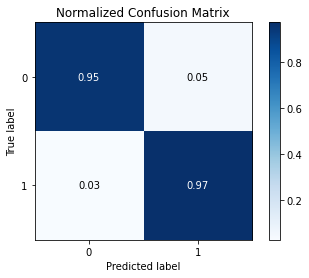

In [14]:
print(metrics.classification_report(y_test, predictions, target_names=[ 'no-scarcity', 'scarcity']))

print("confusion matrix:")
print(metrics.confusion_matrix(y_test, predictions))
print()

skplt.metrics.plot_confusion_matrix(y_test, predictions , normalize=True)
plt.show()

7/7 [==============================] - 0s 2ms/step
Accuracy: 84.42%
              precision    recall  f1-score   support

 no-scarcity       0.82      0.89      0.85       101
    scarcity       0.88      0.80      0.83        98

    accuracy                           0.84       199
   macro avg       0.85      0.84      0.84       199
weighted avg       0.85      0.84      0.84       199

confusion matrix:
[[90 11]
 [20 78]]



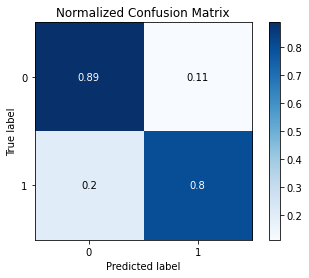

In [15]:
save = pd.read_csv('./data/sample_scarcity.csv')

norm_ = save['ad']
test_ = t.texts_to_sequences(norm_)
padded_ = tf.keras.preprocessing.sequence.pad_sequences(test_, maxlen=MAX_SEQUENCE_LENGTH)

pred_ = model.predict(padded_)
save['predicted'] = [1 if prob > 0.5 else 0 for prob in pred_]

scores = model.evaluate(padded_, save['scarcity'], verbose =False)
print("Accuracy: %.2f%%" % (scores[1]*100))
print(metrics.classification_report(save['scarcity'], save['predicted'], target_names=[ 'no-scarcity', 'scarcity']))
print("confusion matrix:")
print(metrics.confusion_matrix(save['scarcity'], save['predicted']))
print()

skplt.metrics.plot_confusion_matrix(save['scarcity'], save['predicted'], normalize=True)
plt.show()